## date analyst


### проверка и чистка данных

In [1]:
import joblib
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [2]:
# читаем CSV файлы
ga_hits_001_df = pd.read_csv("fin_work/ga_hits-001.csv", low_memory=False)
ga_sessions_df = pd.read_csv("fin_work/ga_sessions.csv", low_memory=False)

# читаем pkl файлы
with open("fin_work/ga_hits-002.pkl", "rb") as f:
    ga_hits_002_df = pickle.load(f)
with open("fin_work/ga_sessions.pkl", "rb") as f:
    ga_sessions_pkl_df = pickle.load(f)


In [3]:
# объединяем в датафрейм
sessions_df = pd.concat([ga_sessions_df, ga_sessions_pkl_df], ignore_index=True)
hits_df = pd.concat([ga_hits_001_df, ga_hits_002_df], ignore_index=True)


In [4]:
# определяем кол-во дубликатов
sessions_df.duplicated().sum()

0

In [5]:
hits_df.duplicated().sum()

0

In [6]:
# определяем кол-во пропусков
sessions_df.isnull().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                      194
utm_medium                        0
utm_campaign                 439206
utm_adcontent                671230
utm_keyword                 2164122
device_category                   0
device_os                   2140276
device_brand                 485856
device_model                3687408
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

In [7]:
hits_df.isnull().sum()

session_id               0
hit_date                 0
hit_time          18320644
hit_number               0
hit_type                 0
hit_referer       12549608
hit_page_path            0
event_category           0
event_action             0
event_label        7520368
event_value       31452940
dtype: int64

In [8]:
missing_values = ((sessions_df.isna().sum() / len(sessions_df)) * 100).sort_values(ascending=False)
print('Процент пропущенных значений sessions_df:', '\n', missing_values)

Процент пропущенных значений sessions_df: 
 device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
utm_adcontent               18.043410
device_brand                13.060350
utm_campaign                11.806346
utm_source                   0.005215
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
geo_city                     0.000000
dtype: float64


In [9]:
missing_values = ((hits_df.isna().sum() / len(hits_df)) * 100).sort_values(ascending=False)
print('Процент пропущенных значений hits_df:', '\n', missing_values)

Процент пропущенных значений hits_df: 
 event_value       100.000000
hit_time           58.247795
hit_referer        39.899634
event_label        23.909905
session_id          0.000000
hit_date            0.000000
hit_number          0.000000
hit_type            0.000000
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
dtype: float64


In [ ]:
msno.matrix(sessions_df)

In [ ]:
msno.matrix(hits_df)

In [10]:
# удаляем неинформативные колонки
hits = hits_df.copy()
hits.drop(columns=['event_value', 'hit_time', 'hit_referer', 'event_label'], inplace=True)

In [11]:
hits.isnull().sum()

session_id        0
hit_date          0
hit_number        0
hit_type          0
hit_page_path     0
event_category    0
event_action      0
dtype: int64

In [12]:
# Заменяем отсутствующие значения в каждом столбце на моду и удаляем неинформативные колонки
sessions = sessions_df.copy()

sessions.drop(columns=['device_model', 'utm_keyword', 'device_os'], inplace=True)

for col in ['utm_adcontent', 'device_brand', 'utm_campaign', 'utm_source']:
    mode_value = sessions[col].mode()[0]  # Получаем моду для текущего столбца
    sessions[col].fillna(mode_value, inplace=True)  # Заменяем отсутствующие значения на моду

print("кол-во пропусков в utm_adcontent", sessions.utm_adcontent.isna().sum())
print("кол-во пропусков в device_brand", sessions.device_brand.isna().sum())
print("кол-во пропусков в utm_campaign", sessions.utm_campaign.isna().sum())
print("кол-во пропусков в utm_source", sessions.utm_source.isna().sum())

кол-во пропусков в utm_adcontent 0
кол-во пропусков в device_brand 0
кол-во пропусков в utm_campaign 0
кол-во пропусков в utm_source 0


In [13]:
sessions.isnull().sum()

session_id                  0
client_id                   0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
dtype: int64

In [14]:
sessions.isnull().values.any()

False

In [15]:
hits.isnull().values.any()

False

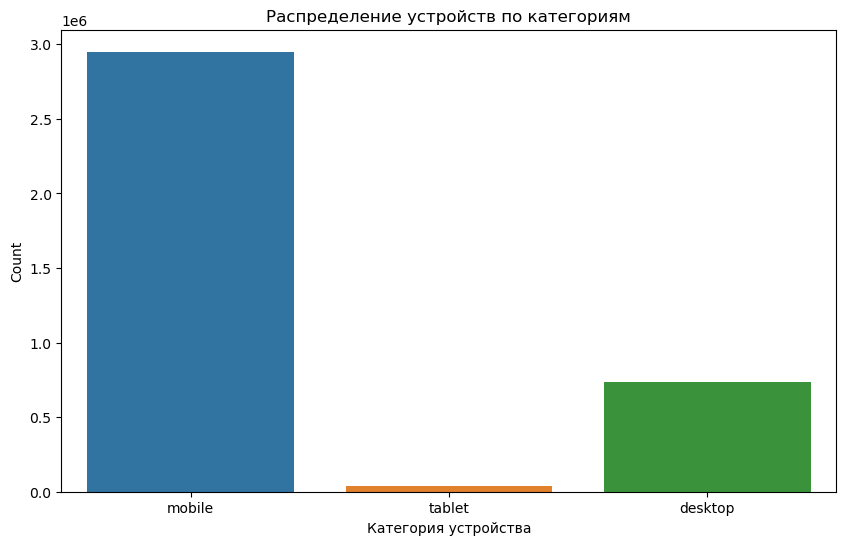

In [16]:
# Распределение ключевых атрибутов
plt.figure(figsize=(10, 6))
sns.countplot(x='device_category', data=sessions)
plt.title('Распределение устройств по категориям')
plt.xlabel('Категория устройства')
plt.ylabel('Count')
plt.show()

In [14]:
target_actions = hits[hits['event_action'].isin(['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
                                                 'sub_custom_question_submit_click', 'sub_call_number_click',
                                                 'sub_callback_submit_click', 'sub_submit_success',
                                                 'sub_car_request_submit_click'])].groupby('session_id').size().reset_index(name='target_actions')

# Объединяем целевые действия с DataFrame
sessions = pd.merge(sessions, target_actions, how='left', on='session_id')


In [15]:
sessions['target_actions'].fillna(0, inplace=True)


In [16]:
# Рассчитываем коэффициент конверсии
sessions['CR'] = sessions['target_actions'] / sessions['visit_number']

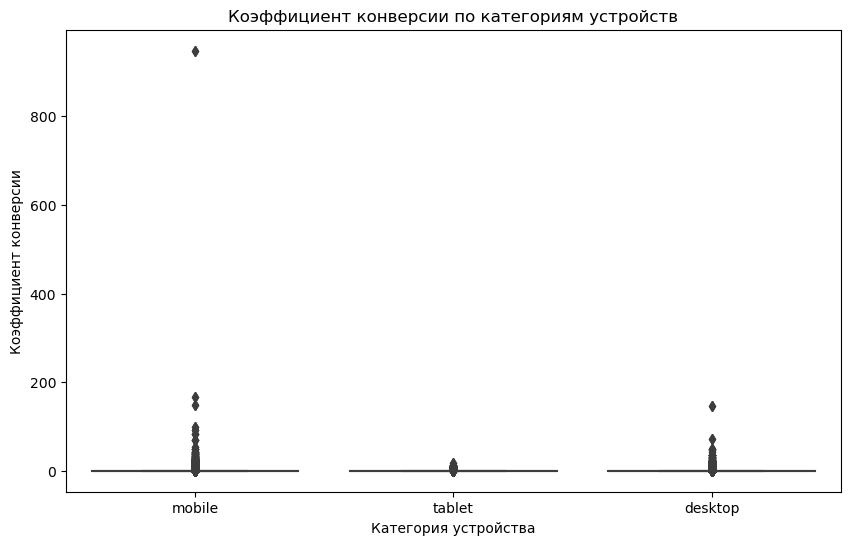

In [20]:
# Взаимосвязь между категорией устройства и коэффициентом конверсии
plt.figure(figsize=(10, 6))
sns.boxplot(x='device_category', y='CR', data=sessions)
plt.title('Коэффициент конверсии по категориям устройств')
plt.xlabel('Категория устройства')
plt.ylabel('Коэффициент конверсии')
plt.show()


In [21]:
device_category_counts = sessions['device_category'].value_counts()
print(device_category_counts)


mobile     2949742
desktop     733726
tablet       36616
Name: device_category, dtype: int64


In [17]:
sessions_1 = sessions.copy()
ohe = OneHotEncoder(sparse=False)
ohe

OneHotEncoder(sparse=False)

In [18]:
ohe.fit(sessions_1[['device_category']])

OneHotEncoder(sparse=False)

In [19]:
ohe_device_category = ohe.transform(sessions_1[['device_category']])
ohe_device_category

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [20]:
ohe.get_feature_names_out()

array(['device_category_desktop', 'device_category_mobile',
       'device_category_tablet'], dtype=object)

In [21]:
sessions_1[ohe.get_feature_names_out()] = ohe_device_category

In [77]:
sessions_1.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_actions,CR,device_category_desktop,device_category_mobile,device_category_tablet
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0.0,0.0,0.0,1.0,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0,0.0,0.0,1.0,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0,0.0,0.0,1.0,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0,0.0,0.0,1.0,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0,0.0,0.0,1.0,0.0


In [23]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5*iqr, q75 + 1.5*iqr)
    return boundaries
boundaries = calculate_outliers(sessions_1[['device_category_mobile', 'device_category_desktop']])
boundaries

(device_category_mobile     1.0
 device_category_desktop    0.0
 dtype: float64,
 device_category_mobile     1.0
 device_category_desktop    0.0
 dtype: float64)

In [24]:
# выбросы
is_outlier = (sessions_1[['device_category_mobile']] < boundaries[0]) | (sessions_1[['device_category_mobile']] > boundaries[1])
is_outlier['device_category_mobile'].sum()


/var/folders/v7/htyd58cd6rb3h4p9l73slr8w0000gn/T/ipykernel_6805/1907952865.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  is_outlier = (sessions_1[['device_category_mobile']] < boundaries[0]) | (sessions_1[['device_category_mobile']] > boundaries[1])
/var/folders/v7/htyd58cd6rb3h4p9l73slr8w0000gn/T/ipykernel_6805/1907952865.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  is_outlier = (sessions_1[['device_category_mobile']] < boundaries[0]) | (sessions_1[['device_category_mobile']] > boundaries[1])


770342

In [25]:
sessions_2 = sessions_1.copy()
sessions_2 = sessions_2[~is_outlier]
is_outlier = (sessions_2[['device_category_mobile']] < boundaries[0]) | (sessions_2[['device_category_mobile']] > boundaries[1])
print('Общее кол-во выбросов в device_category_mobile:', is_outlier['device_category_mobile'].sum())

Общее кол-во выбросов в device_category_mobile: 0


/var/folders/v7/htyd58cd6rb3h4p9l73slr8w0000gn/T/ipykernel_6805/331713441.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  is_outlier = (sessions_2[['device_category_mobile']] < boundaries[0]) | (sessions_2[['device_category_mobile']] > boundaries[1])
/var/folders/v7/htyd58cd6rb3h4p9l73slr8w0000gn/T/ipykernel_6805/331713441.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  is_outlier = (sessions_2[['device_category_mobile']] < boundaries[0]) | (sessions_2[['device_category_mobile']] > boundaries[1])


### проверяем гипотезы

In [64]:
# Нулевая гипотеза (H0): Нет разницы в коэффициенте конверсии между 
# органическим и платным трафиком.
# Альтернативная гипотеза (H1): Существует разница в конверсии между 
# органическим и платным трафиком.

In [26]:
organic_traffic = sessions_2[sessions_2['utm_medium'] == 'organic']
paid_traffic = sessions_2[sessions_2['utm_medium'] == 'paid']

In [27]:
# Рассчитываем коэффициент конверсии для органического трафика
organic_traffic['CR'] = organic_traffic['target_actions'] / organic_traffic['visit_number']

# Рассчитываем коэффициент конверсии для платного трафика
paid_traffic['CR'] = paid_traffic['target_actions'] / paid_traffic['visit_number']

#  Выполняем t-test
t_stat, p_value = ttest_ind(organic_traffic['CR'], paid_traffic['CR'])
 
if p_value < 0.05:
    print("Отклоняем нулевую гипотезу: Существует значительная разница в коэффициенте конверсии между органическим и платным трафиком.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: Нет значимой разницы в конверсии между органическим и платным трафиком.")
    

 

Не удалось отвергнуть нулевую гипотезу: Нет значимой разницы в конверсии между органическим и платным трафиком.


In [28]:
# Мы рассчитали коэффициент конверсии для органического и платного трафика, 
# разделив количество целевых действий на количество посещений.
# Затем мы провели t-тест, чтобы сравнить средние значения коэффициентов 
# конверсии органического и платного трафика.
# По итогам принимаем нулевую гипотезу, т.к. нет значимой разницы между
# органическим и платным трафиком. 


In [29]:
mobile_traffic = sessions_2[sessions_2['device_category'] == 'device_category_mobile']
desktop_traffic = sessions_2[sessions_2['device_category'] == 'device_category_desktop']

# Выполняем t-test
t_stat, p_value = ttest_ind(mobile_traffic['CR'], desktop_traffic['CR'])

if p_value < 0.05:
    print("Отклоняем нулевую гипотезу: Существует значительная разница в коэффициенте конверсии между мобильным и десктопным трафиком.")
else:
    print("Не удается отвергнуть нулевую гипотезу: Нет существенной разницы в коэффициенте конверсии между мобильным и десктопным трафиком.")

Не удается отвергнуть нулевую гипотезу: Нет существенной разницы в коэффициенте конверсии между мобильным и десктопным трафиком.


In [30]:
moscow_petersburg_traffic = sessions_2[sessions_2['geo_city'].isin(['Moscow', 'St. Petersburg'])]
other_regions_traffic = sessions_2[sessions_2['geo_city'].isin(['Moscow', 'St. Petersburg'])]

# Выполняем t-test
t_stat, p_value = ttest_ind(moscow_petersburg_traffic['CR'], other_regions_traffic['CR'])

if p_value < 0.05:
    print("Отклоняем нулевую гипотезу: Существует значительная разница в коэффициенте конверсии между трафиком из Москвы/Санкт-Петербурга и других регионов.")
else:
    print("Не удается отвергнуть нулевую гипотезу: Нет значимой разницы в коэффициенте конверсии между трафиком из Москвы/Санкт-Петербурга и других регионов.")

Не удается отвергнуть нулевую гипотезу: Нет значимой разницы в коэффициенте конверсии между трафиком из Москвы/Санкт-Петербурга и других регионов.


### Из каких источников / кампаний / устройств / локаций к нам идёт самый целевой трафик 
### (и с точки зрения объёма трафика, и с точки зрения CR)?

In [42]:
# Подсчет общего целевого трафика и конверсии для компаний
total_targeted_traffic = company_data['traffic_volume'].sum()
total_company_conversion = (company_data['total_target_actions'].sum() / total_targeted_traffic)

print("Общий объем целевого трафика компаний:", total_targeted_traffic)
print("Общая конверсия компаний:", total_company_conversion)


Общий объем целевого трафика компаний: 3720084
Общая конверсия компаний: 0.1105802987244374


In [41]:
# компания с наибольшим трафиком
company_most_traffic = company_data.loc[company_data['traffic_volume'].idxmax(), 'utm_campaign']
most_traffic_volume = company_data['traffic_volume'].max()

# компания с наибольшей конверсией
company_most_conversions = company_data.loc[company_data['total_target_actions'].idxmax(), 'utm_campaign']
most_conversions = company_data['total_target_actions'].max()

print("Компания с наибольшим трафиком:", company_most_traffic)
print("Объем трафика:", most_traffic_volume)
print("\nКаомпания с наибольшей конверсией:", company_most_conversions)
print("Объем конверсии:", most_conversions)



Компания с наибольшим трафиком: LTuZkdKfxRGVceoWkVyg
Объем трафика: 1366168

Каомпания с наибольшей конверсией: LTuZkdKfxRGVceoWkVyg
Объем конверсии: 217176.0


In [65]:
# общее количество целевого трафика и конверсии для устройств
device_traffic_conversion = sessions_1.groupby('device_category').agg(total_traffic=('session_id', 'count'), total_conversions=('target_actions',
                                                                                                                                'sum')).reset_index()
device_highest_traffic = device_traffic_conversion.loc[device_traffic_conversion['total_traffic'].idxmax(), 'device_category']
device_highest_conversion = device_traffic_conversion.loc[device_traffic_conversion['total_conversions'].idxmax(), 'device_category']

print("Устройство с наибольшим трафиком:", device_highest_traffic)
print("\nУстройство с самой высокой конверсией:", device_highest_conversion)



Устройство с наибольшим трафиком: mobile

Устройство с самой высокой конверсией: mobile


In [63]:
# место с наибольшим трафиком и место с наибольшей конверсией
location_traffic_conversion = sessions_1.groupby(['geo_country', 'geo_city']).agg(total_traffic=('session_id', 'count'),
                                                                                  total_conversions=('target_actions', 'sum')).reset_index()
location_highest_traffic = location_traffic_conversion.loc[location_traffic_conversion['total_traffic'].idxmax(), ['geo_country', 'geo_city']]
location_highest_conversion = location_traffic_conversion.loc[location_traffic_conversion['total_conversions'].idxmax(), ['geo_country', 'geo_city']]

print("Локация с наибольшим объемом трафика:", location_highest_traffic['geo_country'], "-", location_highest_traffic['geo_city'])
print("\nЛокация с наибольшей конверсии:", location_highest_conversion['geo_country'], "-", location_highest_conversion['geo_city'])



Локация с наибольшим объемом трафика: Russia - Moscow

Локация с наибольшей конверсии: Russia - Moscow


In [62]:
# количество целевого трафика и конверсий для источника
source_traffic_conversion = sessions_1.groupby('utm_source').agg(total_traffic=('session_id', 'count'), total_conversions=('target_actions',
                                                                                                                           'sum')).reset_index()
source_highest_traffic = source_traffic_conversion.loc[source_traffic_conversion['total_traffic'].idxmax(), 'utm_source']
source_highest_conversion = source_traffic_conversion.loc[source_traffic_conversion['total_conversions'].idxmax(), 'utm_source']

print("Источник с наибольшим трафиком:", source_highest_traffic)
print("\nИсточник с самой высокой конверсией:", source_highest_conversion)



Источник с наибольшим трафиком: ZpYIoDJMcFzVoPFsHGJL

Источник с самой высокой конверсией: ZpYIoDJMcFzVoPFsHGJL


### Какие авто пользуются наибольшим спросом? 
### У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?

In [166]:
# Извлечение информации о марке и модели автомобиля из 'hit_page_path'
hits[['brand', 'model']] = hits['hit_page_path'].str.extract(r'sberauto\.com/cars/all/(\w+)/(\w+)/')

# Группировка по маркам и моделям автомобилей для расчета объема трафика и коэффициента конверсии
car_traffic_volume = hits.groupby('brand').size().reset_index(name='traffic_volume')
car_conversion_rate = hits[hits['event_action'].isin(['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
                                                      'sub_custom_question_submit_click', 'sub_call_number_click',
                                                      'sub_callback_submit_click', 'sub_submit_success',
                                                      'sub_car_request_submit_click'])].groupby('brand').size() / hits.groupby('brand').size()
car_conversion_rate = car_conversion_rate.reset_index(name='conversion_rate')

# Поиск автомобиля с наибольшим трафиком
max_traffic_car = car_traffic_volume.loc[car_traffic_volume['traffic_volume'].idxmax(), 'brand']
print("Автомобиль с наибольшим количеством трафика:", max_traffic_car)

# Поиск автомобиля с наилучшим коэффициентом конверсии
best_conversion_car = car_conversion_rate.loc[car_conversion_rate['conversion_rate'].idxmax(), 'brand']
print("Автомобиль с наилучшей конверсией:", best_conversion_car)


Автомобиль с наибольшим количеством трафика: skoda
Автомобиль с наилучшей конверсией: hyundai


### Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?

In [66]:
# Фильтруем данные о сеансах для источников рекламы в социальных сетях
social_media_sessions = sessions_1[sessions_1['utm_source'].isin(['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
                                                                  'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'])]

# Рассчитываем объем трафика и коэффициент конверсии для сессий в социальных сетях
social_media_traffic_volume = social_media_sessions.groupby('utm_source').size().reset_index(name='traffic_volume')
social_media_conversion_rate = social_media_sessions['target_actions'].sum() / social_media_sessions['visit_number'].sum()

print("Объем трафика из социальных сетей:")
print(social_media_traffic_volume)

print("\nКоэффициент конверсии из социальных сетей:", social_media_conversion_rate)



Объем трафика из социальных сетей:
             utm_source  traffic_volume
0  ISrKoXQCxqqYvAZICvjs           17266
1  IZEXUFLARCUMynmHNBGo            8842
2  MvfHsxITijuriZxsqZqt          372398
3  PlbkrSYoHuZBWfYjYnfw           41584
4  QxAxdyPLuQMEcrdZWdWb          102830
5  gVRrcxiDQubJiljoTbGm            5534

Коэффициент конверсии из социальных сетей: 0.042659084698017616


In [ ]:
# Для того, чтобы ответить надо или нет увеличивать присутствие в соцсетях и давать там 
# больше рекламы - надо понять какие затраты есть на это. 
# Если исходить только из конверсии, то она достаточно низкая, а значит пользы от соцсетей мало.
# Чтобы увеличить конверсию, то да надо увеличивать рекламу в соцсетях